In [1]:
import sys
sys.path.insert(0, '/tf/pollock')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import pollock
from pollock import PollockDataset, PollockModel, load_from_directory

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [5]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [6]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

In [7]:
run_name = 'sc_brca'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

In [8]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
HT062B1_S1PA_AAACCCACACAAATGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCATCGGAATTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT062B1_S1PA_AAACGAACAGCTAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTCCTCGTGTTACTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT110B1_XB3_TTTGACTCAGGGTCTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df = label_df.set_index('cell_id')
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [10]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

AnnData object with n_obs × n_vars = 49088 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [11]:
## filter to just tumor
tumor_adata = adata[adata.obs[cell_type_key]=='BR_Malignant']
tumor_adata

View of AnnData object with n_obs × n_vars = 10137 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [12]:
## make log2 cpm to match other dataset

In [13]:
stem_expression_fp = '/data/stemness/ERP016000/counts.hd5'
stem_metadata_fp = '/data/stemness/ERP016000/cell_metadata_cols.tsv'

In [14]:
stem_expression_df = pd.read_hdf(stem_expression_fp, 'df')
stem_expression_df.index = [c.split('_')[-1] for c in stem_expression_df.index]
stem_expression_df = stem_expression_df.transpose()
stem_expression_df

,TSPAN6,DPM1,SCYL3,C1orf112,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,...,LUC7L2,ZNF559-ZNF177,HSPE1-MOB4,RPS10-NUDT3,SRGAP2D,MTRNR2L2,SRXN1,GTF2H5,NUDT3,CD24
21843_1#10,5.520777,5.392461,0.000174,1.471928,2.908802,0.127185,0.000000,3.615650,0.000000,5.604953,...,0.575989,0.290480,3.342019,2.955039,0.286690,8.993125,0.000000,1.397666,0.716015,2.578313
21843_1#100,6.456208,6.065923,0.352597,4.536968,3.867327,0.047614,4.277551,0.000000,0.000000,5.848853,...,1.379352,0.000000,2.642681,0.315327,0.446590,10.310311,0.000000,1.399811,1.857059,0.000000
21843_1#101,5.878671,6.838769,0.000000,4.318528,3.321747,4.042388,0.000000,2.545334,0.185345,5.196831,...,3.051514,0.000000,3.053322,1.082602,0.000000,10.112632,0.390075,2.421133,2.499615,0.889010
21843_1#102,4.860824,6.614268,0.825955,5.373009,3.736476,2.662104,1.115943,0.000000,0.000000,3.811312,...,2.453614,0.000000,2.503949,2.271033,0.000000,9.380978,0.000000,2.250520,2.615108,1.963302
21843_1#103,5.903640,6.512403,2.201697,4.636175,4.917576,2.499359,2.278948,2.672572,0.243054,4.964217,...,1.613052,0.000000,2.471723,0.218927,0.000000,9.511378,0.000000,2.633359,1.682406,1.412966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24539_8#93,6.199875,5.885993,0.000000,3.227508,4.221847,0.000000,4.137042,1.758011,0.000000,5.039266,...,1.130735,1.937917,1.906042,1.143744,0.000000,1.709041,0.000000,3.208027,2.139444,7.552773
24539_8#94,7.014180,7.431358,0.108025,2.621121,3.188030,1.393474,3.378998,3.703450,0.139112,4.209373,...,0.403450,1.756385,5.584232,1.768525,0.410279,7.568684,0.000000,4.137374,0.852408,7.631217
24539_8#95,6.228476,7.013124,1.756339,3.950978,4.741496,2.465067,3.069041,2.829073,4.306653,5.019318,...,0.474118,0.279475,5.136851,0.203189,1.306076,6.345048,0.284224,1.847985,1.091890,7.109529
24539_8#97,6.217161,4.851771,2.492943,3.926914,3.872743,3.189254,2.178870,1.834021,0.000000,4.075990,...,1.440802,2.394519,3.511525,1.622543,0.000000,7.577899,0.000000,2.144427,2.796956,7.185068


In [15]:
stem_metadata_df = pd.read_csv(stem_metadata_fp, sep='\t')
stem_metadata_df = stem_metadata_df.loc[stem_expression_df.index]
stem_metadata_df = stem_metadata_df[['assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment',
                          'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type']]
stem_metadata_df

,assigned,cell_name,day,donor_long_id,donor_short_id,experiment,total_counts,total_counts_MT,pseudo,sample_id,well_id,well_type
21843_1#10,1,21843_1#10,day1,HPSI0114i-joxm_1,joxm_1,expt_09,598658.209173,45560.066753,0.292682,21843_1#10,A10,single cell
21843_1#100,1,21843_1#100,day1,HPSI0314i-fafq_1,fafq_1,expt_09,222558.809077,26617.964539,0.484716,21843_1#100,E04,single cell
21843_1#101,1,21843_1#101,day1,HPSI0314i-fafq_1,fafq_1,expt_09,582661.572985,55173.613380,0.403809,21843_1#101,E05,single cell
21843_1#102,1,21843_1#102,day1,HPSI1013i-wuye_2,wuye_2,expt_09,476557.701340,37076.110494,0.260772,21843_1#102,E06,single cell
21843_1#103,1,21843_1#103,day1,HPSI0114i-joxm_1,joxm_1,expt_09,404342.711311,28949.266469,0.355366,21843_1#103,E07,single cell
...,...,...,...,...,...,...,...,...,...,...,...,...
24539_8#93,1,24539_8#93,day1,HPSI0713i-nocf_2,nocf_2,expt_35,347580.461936,31633.724898,0.199677,24539_8#93,D21,single cell
24539_8#94,1,24539_8#94,day1,HPSI1013i-zagm_1,zagm_1,expt_35,395735.359197,56999.061471,0.251769,24539_8#94,D22,single cell
24539_8#95,1,24539_8#95,day1,HPSI0314i-wigw_2,wigw_2,expt_35,474715.299368,37026.549761,0.226935,24539_8#95,D23,single cell
24539_8#97,1,24539_8#97,day1,HPSI1113i-wahn_1,wahn_1,expt_35,75472.999850,4251.880902,0.389748,24539_8#97,E01,single cell


In [16]:
stem_adata = anndata.AnnData(X=stem_expression_df.values, obs=stem_metadata_df)
stem_adata.obs.index = stem_expression_df.index
stem_adata.var.index = stem_expression_df.columns
stem_adata

AnnData object with n_obs × n_vars = 36044 × 11231 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type'

In [17]:
normal_expression_fp = '/data/stemness/br/nguyen/combined.tsv'
# stem_metadata_fp = '/data/stemness/ERP016000/cell_metadata_cols.tsv'

In [18]:
normal_expression_df = pd.read_csv(normal_expression_fp, sep='\t')
normal_expression_df = normal_expression_df.set_index('gene')
normal_expression_df = normal_expression_df.transpose()
normal_expression_df

gene,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsa-mir-1253
GSM3096875_Ind1_Lib3_F5_gene_FPKM_withID,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
GSM3096812_Ind1_Lib2_E10_gene_FPKM_withID,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,2.55,1.80,0.00,4.54,0.00,0.0
GSM3099926_Ind3_Lib1_H2_gene_FPKM_withID,0.0,0.00,0.0,178.14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.24,0.00,0.20,0.00,91.62,3.49,38.95,0.0
GSM3096760_Ind1_Lib2_A4_gene_FPKM_withID,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
GSM3097589_Ind2_Lib2_G5_gene_FPKM_withID,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,1.03,7.23,2.02,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3100033_Ind3_Lib3_C3_gene_FPKM_withID,0.0,0.00,0.0,184.05,0.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,1.30,1.29,3.42,8.16,0.0
GSM3100098_Ind3_Lib5_A7_gene_FPKM_withID,0.0,0.00,0.0,345.98,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,1.00,0.31,281.18,28.07,4.46,0.0
GSM3096747_Ind1_Lib1_H3_gene_FPKM_withID,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,172.77,15.57,0.0
GSM3096870_Ind1_Lib3_E2_gene_FPKM_withID,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,2.72,0.00,0.00,0.00,0.00,0.00,0.0


In [19]:
normal_adata = anndata.AnnData(X=normal_expression_df.values)
normal_adata.obs.index = normal_expression_df.index
normal_adata.var.index = normal_expression_df.columns
normal_adata

AnnData object with n_obs × n_vars = 867 × 32968 

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
... storing 'cancer_type' as categorical
... storing 'tissue_type' as categorical
... storing 'organ_type' as categorical
... storing 'cell_type' as categorical
... storing 'species' as categorical
... storing 'method' as categorical
... storing 'facs' as categorical


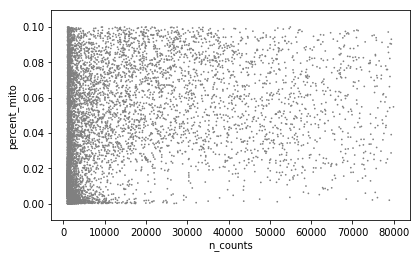

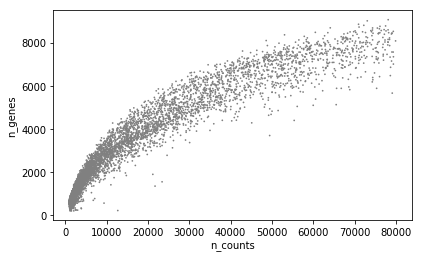

In [20]:
sc.pp.filter_cells(tumor_adata, min_genes=200)
sc.pp.filter_genes(tumor_adata, min_cells=3)

mito_genes = tumor_adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
tumor_adata.obs['percent_mito'] = np.sum(
    tumor_adata[:, mito_genes].X, axis=1) / np.sum(tumor_adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
tumor_adata.obs['n_counts'] = tumor_adata.X.sum(axis=1)

sc.pl.scatter(tumor_adata, x='n_counts', y='percent_mito')
sc.pl.scatter(tumor_adata, x='n_counts', y='n_genes')

In [21]:
sc.pp.normalize_total(tumor_adata, target_sum=1e6)
sc.pp.log1p(tumor_adata)
tumor_adata.raw = tumor_adata
tumor_adata

AnnData object with n_obs × n_vars = 10137 × 23541 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

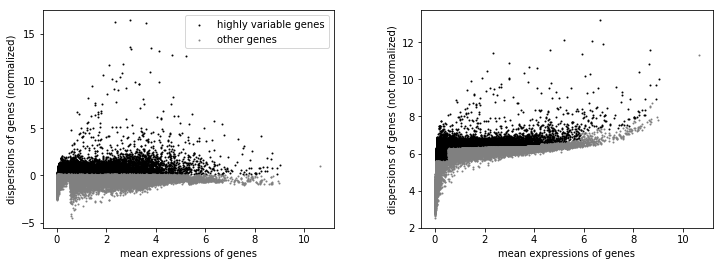

In [22]:
sc.pp.highly_variable_genes(tumor_adata, min_mean=0.0, max_mean=10., min_disp=0.1)
sc.pl.highly_variable_genes(tumor_adata)

In [23]:
np.count_nonzero(tumor_adata.var.highly_variable)

10057

In [24]:
# tumor_adata = tumor_adata[:, tumor_adata.var.highly_variable]
# tumor_adata

In [25]:
stem_adata.raw = stem_adata

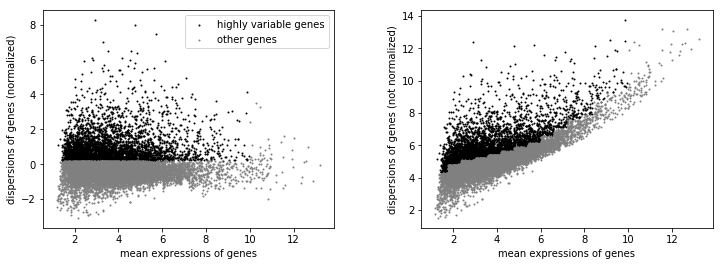

In [26]:
sc.pp.highly_variable_genes(stem_adata, min_mean=0.0, max_mean=10., min_disp=0.2)
sc.pl.highly_variable_genes(stem_adata)

In [27]:
sc.pp.log1p(normal_adata)

normal_adata.raw = normal_adata

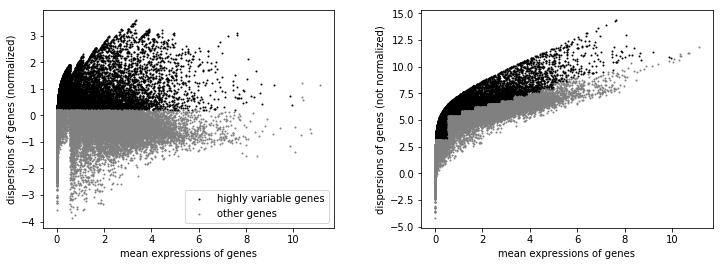

In [28]:
sc.pp.highly_variable_genes(normal_adata, min_mean=0.0, max_mean=10., min_disp=0.2)
sc.pl.highly_variable_genes(normal_adata)

In [29]:
a = set(tumor_adata.var.index)
b = set(stem_adata.var.index)
c = set(normal_adata.var.index)
s = a.intersection(b).intersection(c)
len(s)

10249

In [30]:
tumor_adata = tumor_adata[:, sorted(s)]
stem_adata = stem_adata[:, sorted(s)]
normal_adata = normal_adata[:, sorted(s)]

In [31]:
tumor_adata.obs['dataset'] = 'tumor'
stem_adata.obs['dataset'] = 'stem'
normal_adata.obs['dataset'] = 'normal'

combined_adata = tumor_adata.concatenate(stem_adata, normal_adata)
combined_adata

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 47048 × 10249 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2'

In [32]:
sc.pp.scale(combined_adata, max_value=None)
combined_adata

AnnData object with n_obs × n_vars = 47048 × 10249 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type'
    var: 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2'

In [33]:
sc.tl.pca(combined_adata, svd_solver='arpack')
sc.pp.neighbors(combined_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(combined_adata)

/miniconda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/miniconda/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(p

In [34]:
Counter(combined_adata.obs['day'])

Counter({nan: 11004, 'day1': 9443, 'day3': 8485, 'day0': 9661, 'day2': 8455})

In [35]:
def cap_list(ls, n=100):
    if len(ls) > n:
        return random.sample(ls, n)
    return random.sample(ls, int(len(ls) * .8))

def get_balanced_ids(adata, key, n_per_cell_type):
    cell_type_to_idxs = {}
    for cell_id, cell_type in zip(adata.obs.index, adata.obs[key]):
        if cell_type not in cell_type_to_idxs:
            cell_type_to_idxs[cell_type] = [cell_id]
        else:
            cell_type_to_idxs[cell_type].append(cell_id)

    cell_type_to_idxs = {k:cap_list(ls, n_per_cell_type)
                        for k, ls in cell_type_to_idxs.items()}

    train_ids = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
    val_ids = np.asarray(list(set(adata.obs.index) - set(train_ids)))
    
    return train_ids, val_ids


In [36]:
## grab n tumor cells
n = 5000

cell_ids = np.asarray(combined_adata[combined_adata.obs['dataset']=='tumor'].obs.index)
np.random.shuffle(cell_ids)

train_ids = cell_ids[:n]
val_ids = cell_ids[n:]

stem_train_ids, stem_val_ids = get_balanced_ids(combined_adata[combined_adata.obs['dataset']=='stem'],
                                               'day', 2000)

## grab n tumor cells
n = 500

cell_ids = np.asarray(combined_adata[combined_adata.obs['dataset']=='normal'].obs.index)
np.random.shuffle(cell_ids)

normal_train_ids = cell_ids[:n]
normal_val_ids = cell_ids[n:]



train_ids = np.concatenate((train_ids, stem_train_ids, normal_train_ids))
val_ids = np.concatenate((val_ids, stem_val_ids, normal_val_ids))

train_adata = combined_adata[train_ids].copy()
val_adata = combined_adata[val_ids].copy()

In [37]:
Counter(train_adata.obs['day'])

Counter({nan: 5500, 'day1': 2000, 'day3': 2000, 'day0': 2000, 'day2': 2000})

In [38]:
Counter(val_adata.obs['day'])

Counter({nan: 5504, 'day0': 7661, 'day3': 6485, 'day2': 6455, 'day1': 7443})

In [39]:
from sklearn.preprocessing import MaxAbsScaler
X_train = np.copy(train_adata.X)
X_val = np.copy(val_adata.X)

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

((13500, 10249), (33548, 10249))

In [40]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [59]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [60]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + (alpha * kl_loss))
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [61]:
epochs = 50
latent_dim = 100
# alpha = 0.1
alpha = 2.

model = BVAE(latent_dim, X_train.shape[1])

In [62]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x, alpha=alpha))

    print(f'epoch: {epoch}, val loss: {loss.result()}')

epoch: 1, val loss: 371.1788330078125
epoch: 2, val loss: 363.48834228515625
epoch: 3, val loss: 353.0140380859375
epoch: 4, val loss: 349.09173583984375
epoch: 5, val loss: 346.42657470703125
epoch: 6, val loss: 344.6112976074219
epoch: 7, val loss: 342.8265380859375
epoch: 8, val loss: 340.16107177734375
epoch: 9, val loss: 338.2433166503906
epoch: 10, val loss: 336.95452880859375
epoch: 11, val loss: 335.44085693359375
epoch: 12, val loss: 334.1325378417969
epoch: 13, val loss: 333.2450866699219
epoch: 14, val loss: 332.5714416503906
epoch: 15, val loss: 331.88641357421875
epoch: 16, val loss: 331.2733459472656
epoch: 17, val loss: 330.9268798828125
epoch: 18, val loss: 330.5169982910156
epoch: 19, val loss: 330.0968322753906
epoch: 20, val loss: 329.7121276855469
epoch: 21, val loss: 329.50189208984375
epoch: 22, val loss: 329.1389465332031
epoch: 23, val loss: 328.8077697753906
epoch: 24, val loss: 328.6855773925781
epoch: 25, val loss: 328.37164306640625
epoch: 26, val loss: 328.

In [63]:
mean, logvar = model.encode(combined_adata.X)
cell_embeddings = model.reparameterize(mean, logvar).numpy()
cell_embeddings.shape

(47048, 100)

In [64]:
import umap
combined_adata.obsm['cell_embeddings'] = cell_embeddings
combined_adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(combined_adata.obsm['cell_embeddings'])
combined_adata.obs['cell_embedding_umap1'] = combined_adata.obsm['cell_embedding_umap'][:, 0]
combined_adata.obs['cell_embedding_umap2'] = combined_adata.obsm['cell_embedding_umap'][:, 1]

combined_adata

/miniconda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


AnnData object with n_obs × n_vars = 47048 × 10249 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type', 'cell_embedding_umap1', 'cell_embedding_umap2', 'tumor_sample_id', 'tumor_to_stem_embeddings_umap1', 'tumor_to_stem_embeddings_umap2'
    var: 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2'
    uns: 'pca', 'neighbors', 'umap', 'dataset_colors', 'tumor_sample_id_colors', 'day_colors'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap', 'tumor_to_stem_embeddings', 'tumor_to_stem_embeddings_umap'
    varm: 'PCs'

In [65]:
combined_adata.obs

,assigned,batch,cancer_type,cell_name,cell_type,dataset,day,donor_long_id,donor_short_id,experiment,...,tissue_type,total_counts,total_counts_MT,well_id,well_type,cell_embedding_umap1,cell_embedding_umap2,tumor_sample_id,tumor_to_stem_embeddings_umap1,tumor_to_stem_embeddings_umap2
HT062B1_S1PA_AAACGAACAGCTAACT-1-0,NaN,0,Breast Cancer,nan,BR_Malignant,tumor,nan,nan,nan,nan,...,Epithelial,NaN,NaN,nan,nan,10.489917,1.235752,TWCE-HT062B1-S1PAA1A1Z1B1,0.183668,3.768395
HT062B1_S1PA_AAACGCTAGGTGATAT-1-0,NaN,0,Breast Cancer,nan,BR_Malignant,tumor,nan,nan,nan,nan,...,Epithelial,NaN,NaN,nan,nan,11.257905,-0.739600,TWCE-HT062B1-S1PAA1A1Z1B1,-1.402559,8.851143
HT062B1_S1PA_AAACGCTAGTTCACTG-1-0,NaN,0,Breast Cancer,nan,BR_Malignant,tumor,nan,nan,nan,nan,...,Epithelial,NaN,NaN,nan,nan,10.703011,1.160017,TWCE-HT062B1-S1PAA1A1Z1B1,0.555293,3.933714
HT062B1_S1PA_AAACGCTAGTTCTCTT-1-0,NaN,0,Breast Cancer,nan,BR_Malignant,tumor,nan,nan,nan,nan,...,Epithelial,NaN,NaN,nan,nan,10.861327,0.717477,TWCE-HT062B1-S1PAA1A1Z1B1,0.394886,4.186403
HT062B1_S1PA_AAACGCTTCTGAACGT-1-0,NaN,0,Breast Cancer,nan,BR_Malignant,tumor,nan,nan,nan,nan,...,Epithelial,NaN,NaN,nan,nan,10.567634,1.263048,TWCE-HT062B1-S1PAA1A1Z1B1,0.439953,3.482072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3100033_Ind3_Lib3_C3_gene_FPKM_withID-2,NaN,2,nan,nan,nan,normal,nan,nan,nan,nan,...,nan,NaN,NaN,nan,nan,8.847433,-0.948940,stem,-0.502932,0.152929
GSM3100098_Ind3_Lib5_A7_gene_FPKM_withID-2,NaN,2,nan,nan,nan,normal,nan,nan,nan,nan,...,nan,NaN,NaN,nan,nan,8.671864,-1.087263,stem,0.224546,0.580523
GSM3096747_Ind1_Lib1_H3_gene_FPKM_withID-2,NaN,2,nan,nan,nan,normal,nan,nan,nan,nan,...,nan,NaN,NaN,nan,nan,8.592274,-1.153920,stem,-0.846778,2.123822
GSM3096870_Ind1_Lib3_E2_gene_FPKM_withID-2,NaN,2,nan,nan,nan,normal,nan,nan,nan,nan,...,nan,NaN,NaN,nan,nan,9.138120,-0.721855,stem,0.169964,3.573891


In [66]:
# combined_adata.obs['normalized_sample_id'] = [x.split('_')[0] for x in combined_adata.obs['sample_id']]
combined_adata.obs['tumor_sample_id'] = [s if d == 'tumor' else 'stem'
        for d, s in zip(combined_adata.obs['dataset'], combined_adata.obs['sample_id'])]


... storing 'tumor_sample_id' as categorical


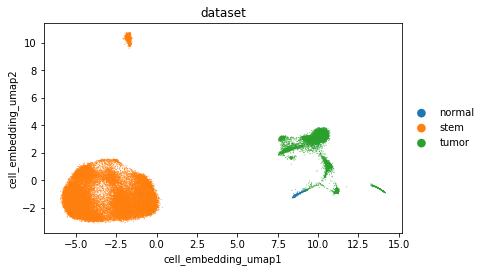

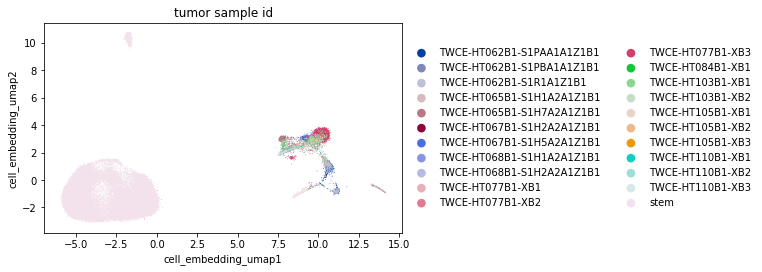

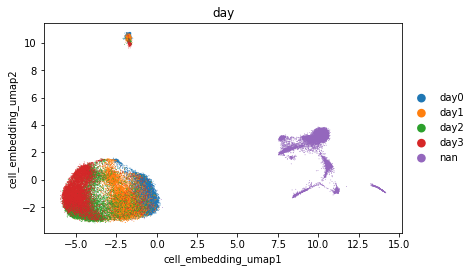

In [67]:
variables = ['dataset', 'tumor_sample_id', 'day']
# variables += br_stem_markers
for var in variables:
    sc.pl.scatter(combined_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [68]:
## try to broadcast together
combined_adata.obsm['cell_embeddings']

array([[-0.36320826, -0.738804  ,  0.8306824 , ...,  1.0351607 ,
        -0.86990124, -0.73307276],
       [-0.78260624,  0.9812079 , -0.18808424, ..., -0.2555796 ,
         0.2997349 , -1.1155394 ],
       [-0.14123292,  1.3846623 , -0.31101817, ..., -0.9695341 ,
         0.49866754,  0.52121705],
       ...,
       [ 0.35515505, -0.8711308 ,  0.27297744, ...,  1.3117164 ,
         0.69479406,  0.9411007 ],
       [ 0.26187754, -0.61725414, -0.7671625 , ..., -0.1626923 ,
        -1.1632179 ,  1.3361572 ],
       [-0.268675  , -1.3173748 ,  0.8932106 , ...,  0.03103794,
        -1.1657659 , -1.0312886 ]], dtype=float32)

In [69]:
avg_tumor = np.mean(combined_adata[combined_adata.obs['dataset']=='tumor'].obsm['cell_embeddings'], axis=0)
avg_stem = np.mean(combined_adata[combined_adata.obs['dataset']=='stem'].obsm['cell_embeddings'], axis=0)
avg_normal = np.mean(combined_adata[combined_adata.obs['dataset']=='normal'].obsm['cell_embeddings'], axis=0)

mean = np.mean(np.asarray([avg_tumor, avg_stem, avg_normal]), axis=0)

delta = avg_stem - avg_tumor - avg_normal

stem_delta = mean - avg_stem
tumor_delta = mean - avg_tumor
normal_delta = mean - avg_normal

In [70]:
def operation(latent, dataset):
    if dataset == 'stem': return latent + stem_delta
    if dataset == 'tumor': return latent + tumor_delta
    if dataset == 'normal': return latent + normal_delta

tumor_to_stem_embeddings = np.asarray([operation(latent, dataset)
                           for latent, dataset in zip(combined_adata.obsm['cell_embeddings'],
                                                      combined_adata.obs['dataset'])])

# tumor_to_stem_embeddings = np.asarray([latent + delta if dataset == 'tumor' else latent
#                            for latent, dataset in zip(combined_adata.obsm['cell_embeddings'],
#                                                       combined_adata.obs['dataset'])])
combined_adata.obsm['tumor_to_stem_embeddings'] = tumor_to_stem_embeddings
combined_adata.obsm['tumor_to_stem_embeddings_umap'] = umap.UMAP(
    ).fit_transform(combined_adata.obsm['tumor_to_stem_embeddings'])
combined_adata.obs['tumor_to_stem_embeddings_umap1'] = combined_adata.obsm['tumor_to_stem_embeddings_umap'][:, 0]
combined_adata.obs['tumor_to_stem_embeddings_umap2'] = combined_adata.obsm['tumor_to_stem_embeddings_umap'][:, 1]

combined_adata

/miniconda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


AnnData object with n_obs × n_vars = 47048 × 10249 
    obs: 'assigned', 'batch', 'cancer_type', 'cell_name', 'cell_type', 'dataset', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'facs', 'method', 'n_counts', 'n_genes', 'organ_type', 'percent_mito', 'pseudo', 'sample_id', 'species', 'tissue_type', 'total_counts', 'total_counts_MT', 'well_id', 'well_type', 'cell_embedding_umap1', 'cell_embedding_umap2', 'tumor_sample_id', 'tumor_to_stem_embeddings_umap1', 'tumor_to_stem_embeddings_umap2'
    var: 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2'
    uns: 'pca', 'neighbors', 'umap', 'dataset_colors', 'tumor_sample_id_colors', 'day_colors'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap', 'tumor_to_stem_embeddings', 'tumor_to_stem_embeddings_umap'
    varm: 'PCs'

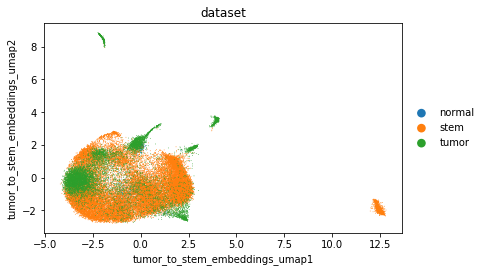

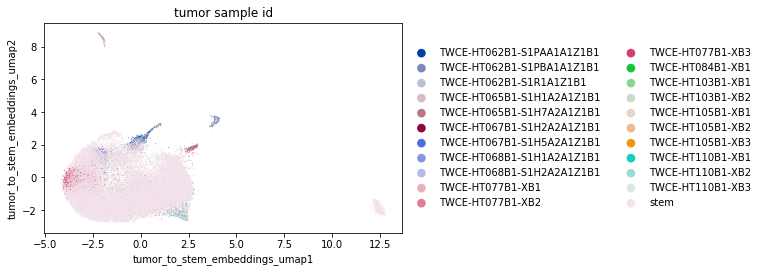

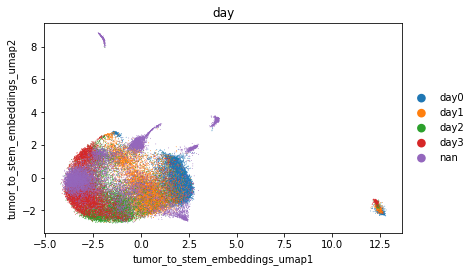

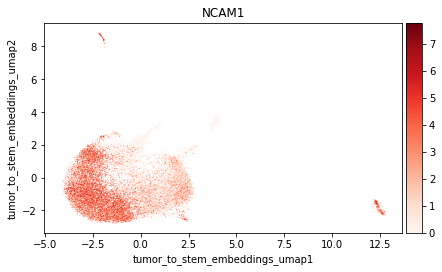

In [71]:
variables = ['dataset', 'tumor_sample_id', 'day', 'NCAM1']
# variables += br_stem_markers
for var in variables:
    sc.pl.scatter(combined_adata, x='tumor_to_stem_embeddings_umap1',
                  y='tumor_to_stem_embeddings_umap2', color=var,
                  frameon=False, color_map='Reds')
    plt.show()

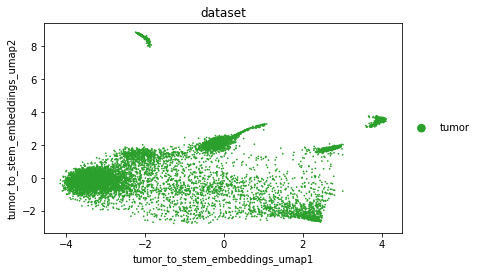

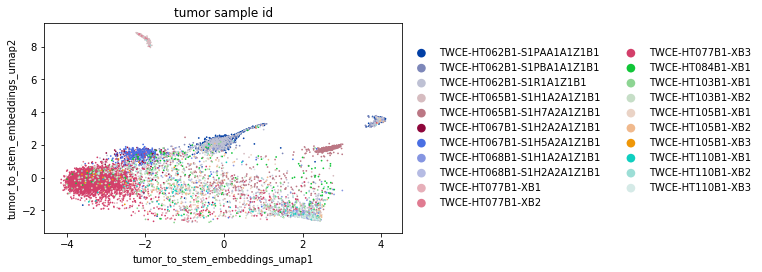

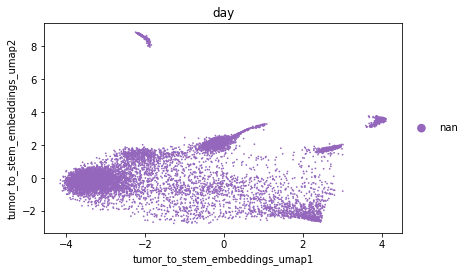

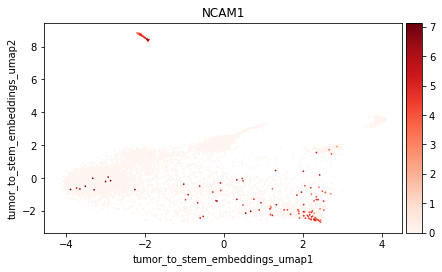

In [72]:
variables = ['dataset', 'tumor_sample_id', 'day', 'NCAM1']
# variables += br_stem_markers
for var in variables:
    sc.pl.scatter(combined_adata[combined_adata.obs['dataset']=='tumor'], x='tumor_to_stem_embeddings_umap1',
                  y='tumor_to_stem_embeddings_umap2', color=var,
                  frameon=False, color_map='Reds')
    plt.show()

In [ ]:
# import re
# cell_ids = np.asarray([re.sub(r'^(.*)-0$', r'\1', x)
#                        for x in combined_adata[combined_adata.obs['dataset']=='tumor'].obs.index])

# set(tumor_adata.obs.index).intersection(set(cell_ids))

In [ ]:
## map back to original tumor adata so you have all the genes
import re
cell_ids = np.asarray([re.sub(r'^(.*)-0$', r'\1', x)
                       for x in combined_adata[combined_adata.obs['dataset']=='tumor'].obs.index])


transformed_tumor_adata = anndata.AnnData(X=tumor_adata[cell_ids].raw.X,
                                         obs=combined_adata[combined_adata.obs['dataset']=='tumor'].obs,
                                         obsm=combined_adata[combined_adata.obs['dataset']=='tumor'].obsm,
                                         var=tumor_adata[cell_ids].raw.var)


transformed_tumor_adata

In [ ]:
'NCAM1' in transformed_tumor_adata.var.index

In [ ]:
# br_stem_markers = ['CD24', 'ITGB1', 'EPCAM', 'CD44', 'PROM1', 'NCAM1', 'SOX2']
br_stem_markers = ['CD24', 'CD44', 'SOX2', 'NCAM1', 'POU5F1', 'NANOG', 'SP5', 'MYL7', 'COL5A2', 'ATXN1',
                  'LY6A']

In [ ]:
variables = ['dataset', 'tumor_sample_id']
variables += br_stem_markers
for var in variables:
    if var in transformed_tumor_adata.var.index:
        sc.pl.scatter(transformed_tumor_adata, x='tumor_to_stem_embeddings_umap1',
                      y='tumor_to_stem_embeddings_umap2', color=var,
                      frameon=False, color_map='Reds')
        plt.show()

In [ ]:
## map back to original tumor adata so you have all the genes
import re
cell_ids = np.asarray([re.sub(r'^(.*)-1$', r'\1', x)
                       for x in combined_adata[combined_adata.obs['dataset']=='stem'].obs.index])


transformed_stem_adata = anndata.AnnData(X=stem_adata[cell_ids].raw.X,
                                         obs=combined_adata[combined_adata.obs['dataset']=='stem'].obs,
                                         obsm=combined_adata[combined_adata.obs['dataset']=='stem'].obsm,
                                         var=stem_adata[cell_ids].raw.var)


transformed_stem_adata

In [ ]:
variables = ['dataset', 'day']
variables += br_stem_markers
for var in variables:
    if var in transformed_stem_adata.var.index:
        sc.pl.scatter(transformed_stem_adata, x='tumor_to_stem_embeddings_umap1',
                      y='tumor_to_stem_embeddings_umap2', color=var,
                      frameon=False, color_map='Reds')
        plt.show()

In [ ]:
sc.tl.rank_genes_groups(transformed_stem_adata, 'day')
sc.pl.rank_genes_groups(transformed_stem_adata, n_genes=25, sharey=False)

In [ ]:
pds = PollockDataset(adata.copy(), cell_type_key=cell_type_key, n_per_cell_type=500, batch_size=128,
                    dataset_type='training', min_genes=200, min_cells=3, mito_threshold=None,
                    max_n_genes=None, log=True, cpm=False, min_disp=.2)